In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
from matplotlib import figure
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from random import randrange
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from skorch import NeuralNetBinaryClassifier, NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Callback

In [2]:
# Settings:
pd.set_option('display.width', 190)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 50)
pd.set_option('max_colwidth', 200)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('default')
np.set_printoptions(threshold = 30, edgeitems = 30, precision = 2, suppress = False)

In [3]:
def split_sequences(Xs, ys, n_steps):
    X, y = list(), list()
    for i in range(len(ys)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(ys):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = Xs[i: end_ix], ys[end_ix - 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y).squeeze()

In [4]:
df_path = "../merged_data/CAPE_BAAFFM_BCI_CCI_CLI_IJC_PMIC_T10Y2Y_T10Y3M_vs_USRESCD_GDP.csv"
features = ['CAPE', "BAAFFM", "BCI", "CCI", "CLI", "IJC", "PMIC", "T10Y2Y", "T10Y3M"]
model_names_classification = ["Logistic Regression", "Penalized SVM", "Random Forest", "LSTM"]
model_names_regression = ["Linear Regression", "LSTM"]
LSTM_length = 10


In [5]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()

        self.lstm = nn.LSTM(input_size=len(features), hidden_size=LSTM_length, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.dense = nn.Linear(LSTM_length, 1)

    def forward(self, X, **kwargs):
        output, hidden = self.lstm(X)
        X = self.dense(self.dropout(output[:, -1, :]))
        return X

    
class FixRandomSeed(Callback):
    
    def __init__(self, seed=1):
        self.seed = seed
    
    def initialize(self):
        print("setting random seed to: ",self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        
        try:
            random.seed(self.seed)
        except NameError:
            import random
            random.seed(self.seed)

        np.random.seed(self.seed)
        torch.backends.cudnn.deterministic=True
        
        
def get_LSTM_classification_model():
    model = NeuralNetBinaryClassifier(
        MyModule,
        optimizer=Adam,
        max_epochs=10,
        lr=1e-4,
        batch_size=64,
        iterator_train__shuffle=True,
        verbose=0,
        callbacks=[FixRandomSeed()]
    )
    return model

def get_LSTM_regression_model():
    model = NeuralNetRegressor(
        MyModule,
        optimizer=Adam,
        max_epochs=10,
        lr=1e-3,
        batch_size=64,
        iterator_train__shuffle=True,
        verbose=0,
        callbacks=[FixRandomSeed()]
    )
    return model

In [6]:
get_classification_models = [lambda: linear_model.LogisticRegression(), lambda: svm.SVC(kernel='linear',\
    class_weight='balanced', probability=True, max_iter=1000, random_state=1), lambda: RandomForestClassifier(random_state=1), lambda: get_LSTM_classification_model()]
get_regression_models = [lambda: linear_model.LinearRegression(), lambda: get_LSTM_regression_model()]
target_variables_classification = ["USRECD"]
target_variables_regression = ["GDP_rate", "GDP_abs"]
target_variables = target_variables_classification + target_variables_regression

In [7]:
# Read the data and do a little bit of wrangling:
df = pd.read_csv(df_path)
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date", drop=True)
df = df.dropna()


In [8]:
# Split into training and test sets and hold out the test set until the end, so that it remains "unseen".
lag_of_y = 180 # This is the lag in days we introduce to the predictor variable so that we assess 
              # the indicator's ability to predict the target variable this many steps into the future.

df_x = df.iloc[:-lag_of_y][df.columns.difference(target_variables)]
df_y = df.iloc[lag_of_y:][target_variables]
        
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, shuffle=False)


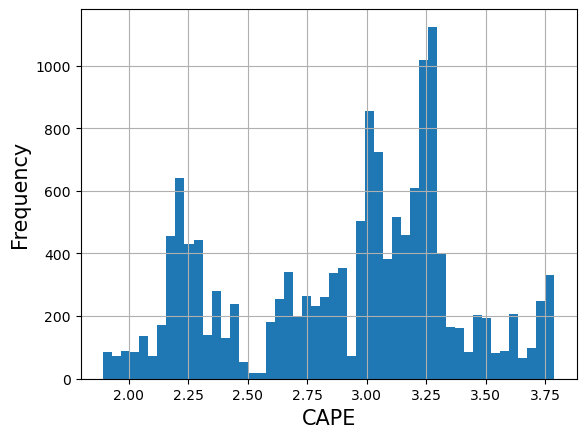

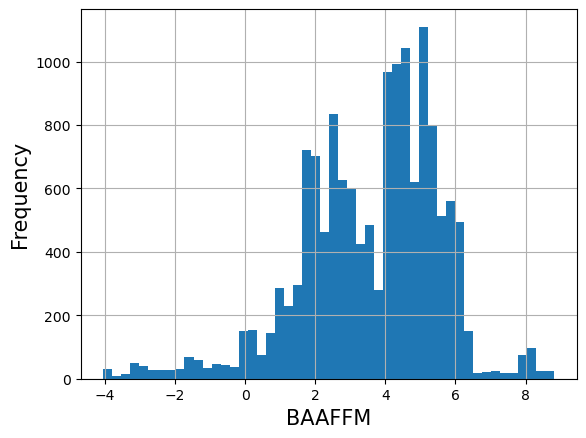

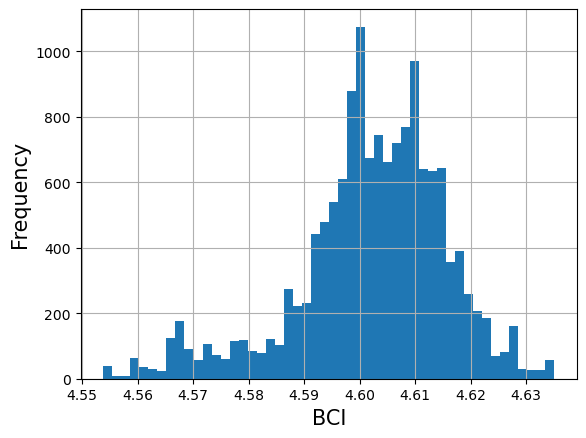

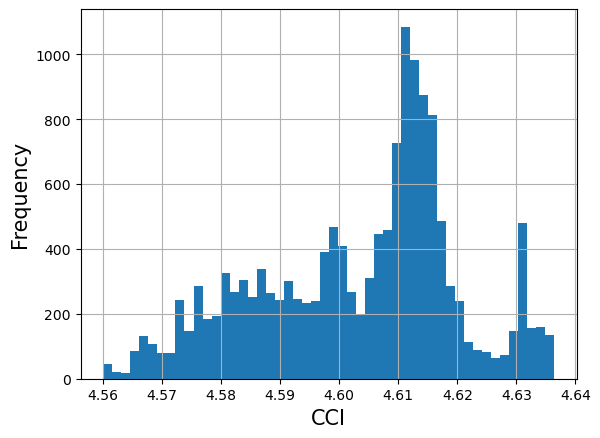

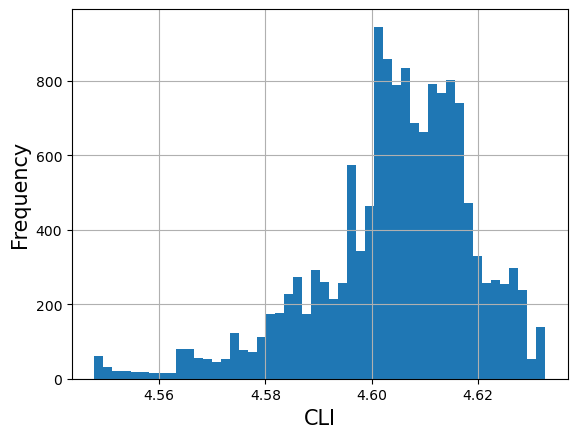

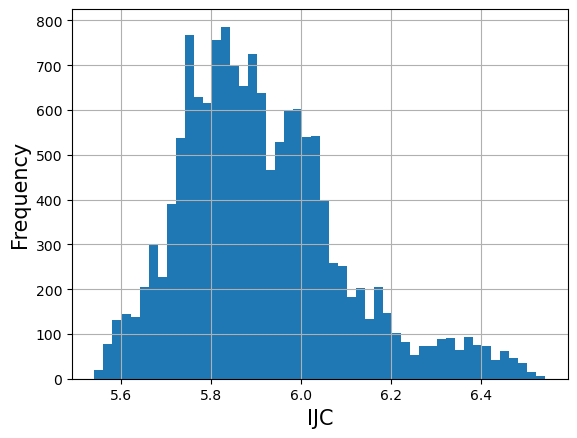

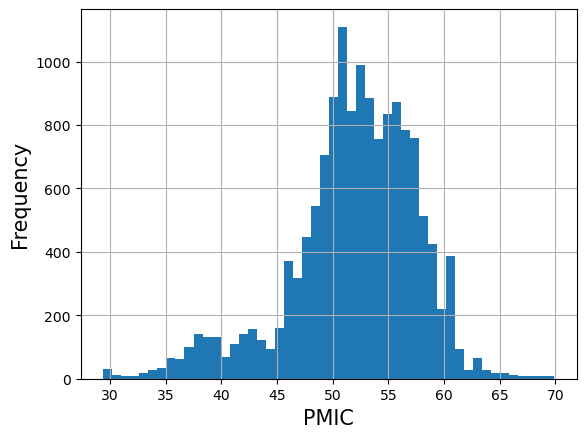

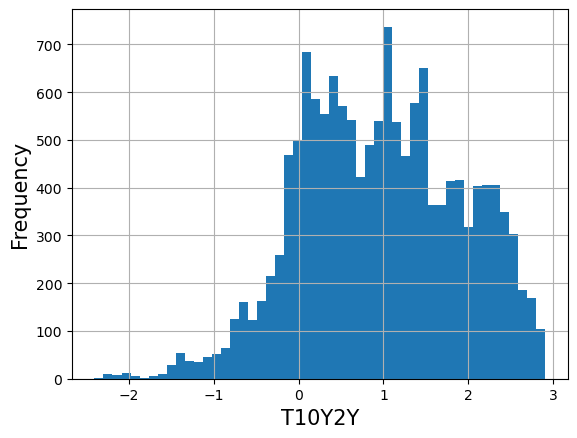

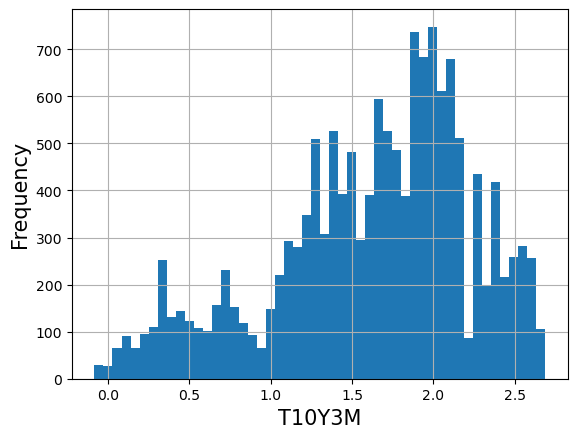

In [9]:
# Histrograms of the features in training set before any scaling
for feature in features:
    plt.figure()
    X_train[feature].hist(bins = 50)
    plt.xlabel(feature,fontsize=15)
    plt.ylabel("Frequency",fontsize=15)
    plt.show()


 ## Validation

In [10]:
# Do a time series cross-validation on the test set by splitting it into k folds and doing a "rolling"
# validation against a validation fold, then averaging out the metrics.
splits = 3 # This is the number of splits/folds in the rolling validation.
tscv = TimeSeriesSplit(n_splits=splits)
pd.options.mode.chained_assignment = None

AUC_ROCs = dict()
ACCs = dict()


In [11]:
## Classification
for target_variable in target_variables_classification:
    print(target_variable)
    for model_name, get_model in zip(model_names_classification, get_classification_models):
        print(model_name)
        AUC_ROCs[model_name] = 0
        ACCs[model_name] = 0
        for train_index, test_index in tscv.split(X_train): # Rolling cross-validation happens inside this loop.
            X_train_fold, X_validation_fold = X_train.iloc[train_index,][features], X_train.iloc[test_index,][features]
            y_train_fold, y_validation_fold = y_train.iloc[train_index,][[target_variable]], y_train.iloc[test_index,][[target_variable]]
            
            scalers = dict()
            for feature in features:
                scalers[feature] = StandardScaler()
                scalers[feature].fit(X_train_fold[[feature]]) # Do z-score scaling on the training fold...
                X_train_fold[feature] = scalers[feature].transform(X_train_fold[[feature]])
                X_validation_fold[feature] = scalers[feature].transform(X_validation_fold[[feature]]) # ...and use the same
                # scaling parameters to transform the validation fold to the same scale with it (to avoid data leakage)
                
            if model_name == 'LSTM':
                X_train_fold_original = X_train_fold.copy()
                y_train_fold_original = y_train_fold.copy()
                X_train_fold, y_train_fold = split_sequences(X_train_fold.to_numpy(), y_train_fold.to_numpy(), n_steps=LSTM_length)
                X_train_fold = X_train_fold.astype(np.float32)
                y_train_fold = y_train_fold.astype(np.float32)
                X_validation_fold = pd.concat([X_train_fold_original.iloc[-LSTM_length+1:], X_validation_fold])
                y_validation_fold = pd.concat([y_train_fold_original.iloc[-LSTM_length+1:], y_validation_fold])
                X_validation_fold, y_validation_fold = split_sequences(X_validation_fold.to_numpy(), y_validation_fold.to_numpy(), n_steps=LSTM_length)
                X_validation_fold = X_validation_fold.astype(np.float32)
                y_validation_fold = y_validation_fold.astype(np.float32)
                
            model = get_model()
            if model_name != 'LSTM':
                model.fit(X_train_fold[features], y_train_fold[target_variable])
                positive_probs = [p[1] for p in model.predict_proba(X_validation_fold[features])]
            else:
                model.fit(X_train_fold, y_train_fold)
                positive_probs = [p[1] for p in model.predict_proba(X_validation_fold)]
            
            AUC_ROC = metrics.roc_auc_score(y_validation_fold, positive_probs)
            AUC_ROCs[model_name] += AUC_ROC
            
            if model_name != 'LSTM':
                predictions = model.predict(X_validation_fold[features])
            else:
                predictions = model.predict(X_validation_fold)
                
            ACC = accuracy_score(y_validation_fold, predictions)
            ACCs[model_name] += ACC
            print("AUC_ROC:", AUC_ROC, "\tAccuracy:", ACC)
            
        AUC_ROCs[model_name] /= splits
        ACCs[model_name] /= splits

    for model_name in model_names_classification:
        print(model_name)
        print(f"Average training AUC ROC: {AUC_ROCs[model_name]}")
        print(f"Average training accuracy: {ACCs[model_name]}")


USRECD
Logistic Regression
AUC_ROC: 0.8167786526112509 	Accuracy: 0.9061470911086718
AUC_ROC: 0.8433739151398263 	Accuracy: 0.9330406147091108
AUC_ROC: 0.8000937393561853 	Accuracy: 0.8498902305159166
Penalized SVM


/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


AUC_ROC: 0.6970026971007075 	Accuracy: 0.12047200878155873


/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


AUC_ROC: 0.6215863066538092 	Accuracy: 0.7615257958287596


/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


AUC_ROC: 0.7866750803838591 	Accuracy: 0.7972008781558727
Random Forest
AUC_ROC: 0.6968774616035225 	Accuracy: 0.9333150384193194
AUC_ROC: 0.9259215284474447 	Accuracy: 0.9330406147091108
AUC_ROC: 0.8672628875381554 	Accuracy: 0.8498902305159166
LSTM
setting random seed to:  1
AUC_ROC: 0.8375610901175278 	Accuracy: 0.9333150384193194
setting random seed to:  1
AUC_ROC: 0.9922299903567985 	Accuracy: 0.9330406147091108
setting random seed to:  1
AUC_ROC: 0.6533391103851754 	Accuracy: 0.8498902305159166
Logistic Regression
Average training AUC ROC: 0.8200821023690876
Average training accuracy: 0.8963593121112331
Penalized SVM
Average training AUC ROC: 0.701754694712792
Average training accuracy: 0.5597328942553971
Random Forest
Average training AUC ROC: 0.8300206258630408
Average training accuracy: 0.9054152945481156
LSTM
Average training AUC ROC: 0.8277100636198339
Average training accuracy: 0.9054152945481156


In [12]:
## Regression
R2s = dict()
for target_variable in target_variables_regression:
    print(target_variable)
    for model_name, get_model in zip(model_names_regression, get_regression_models):
        print()
        print(model_name)
        R2s[model_name] = 0
        for train_index, test_index in tscv.split(X_train): # Rolling cross-validation happens inside this loop.
            X_train_fold, X_validation_fold = X_train.iloc[train_index,][features], X_train.iloc[test_index,][features]
            y_train_fold, y_validation_fold = y_train.iloc[train_index,][[target_variable]], y_train.iloc[test_index,][[target_variable]]
                
            scalers = dict()
            for feature in features:
                scalers[feature] = StandardScaler()
                scalers[feature].fit(X_train_fold[[feature]])
                X_train_fold[feature] = scalers[feature].transform(X_train_fold[[feature]])
                X_validation_fold[feature] = scalers[feature].transform(X_validation_fold[[feature]])
                
            if model_name == 'LSTM':
                X_train_fold_original = X_train_fold.copy()
                y_train_fold_original = y_train_fold.copy()
                X_train_fold, y_train_fold = split_sequences(X_train_fold.to_numpy(), y_train_fold.to_numpy(), n_steps=LSTM_length)
                X_train_fold = X_train_fold.astype(np.float32)
                y_train_fold = y_train_fold.astype(np.float32)
                X_validation_fold = pd.concat([X_train_fold_original.iloc[-LSTM_length+1:], X_validation_fold])
                y_validation_fold = pd.concat([y_train_fold_original.iloc[-LSTM_length+1:], y_validation_fold])
                X_validation_fold, y_validation_fold = split_sequences(X_validation_fold.to_numpy(), y_validation_fold.to_numpy(), n_steps=LSTM_length)
                X_validation_fold = X_validation_fold.astype(np.float32)
                y_validation_fold = y_validation_fold.astype(np.float32)
                
            model = get_model()
            if model_name != 'LSTM':
                model.fit(X_train_fold[features], y_train_fold[target_variable])
                predictions = model.predict(X_validation_fold[features])
                R2 = r2_score(y_validation_fold[target_variable], predictions)
            else:
                model.fit(X_train_fold, y_train_fold.reshape(-1, 1))
                predictions = model.predict(X_validation_fold)
                R2 = r2_score(y_validation_fold, predictions)
            R2s[model_name] += R2
            print(R2)
            
        R2s[model_name] /= splits
    for model_name in model_names_regression:
        print(model_name)
        print(f"Average training R2 score: {R2s[model_name]}")


GDP_rate

Linear Regression
-2.129270723564866
-0.5354290106728852
-1.998006032703084

LSTM
setting random seed to:  1
-0.5062697671063219
setting random seed to:  1
-0.3505997595197279
setting random seed to:  1
-0.41583292240992087
Linear Regression
Average training R2 score: -1.554235255646945
LSTM
Average training R2 score: -0.42423414967865686
GDP_abs

Linear Regression
-2.5390850281626496
-4.3159599711260705
-10.432547158096979

LSTM
setting random seed to:  1
-41.28272657698457
setting random seed to:  1
-45.784007944305245
setting random seed to:  1
-117.426930036259
Linear Regression
Average training R2 score: -5.762530719128566
LSTM
Average training R2 score: -68.16455485251628


 ## Test

In [13]:
y_test.value_counts()


USRECD  GDP_rate  GDP_abs   
0       -31.2000  21120.3198    1
        3.1544    20461.4897    1
        3.1648    21493.1579    1
        3.1641    19956.6555    1
        3.1626    20525.4478    1
        3.1622    20457.6144    1
        3.1609    21521.4856    1
        3.1593    20523.6169    1
        3.1565    21523.5448    1
        3.1560    21490.7871    1
                  20521.7861    1
        3.1554    20682.5707    1
        3.1543    19953.8213    1
        3.1391    21531.7815    1
        3.1527    20519.9552    1
        3.1522    21525.6040    1
        3.1495    20518.1243    1
        3.1478    21527.6632    1
        3.1473    21488.4163    1
        3.1467    20465.3650    1
        3.1462    20516.2934    1
        3.1446    19950.9870    1
        3.1435    21529.7223    1
        3.1429    20514.4625    1
        3.1652    21519.4264    1
                               ..
        2.1120    20789.8563    1
        2.1446    21541.5884    1
        2.1130    1

In [14]:
X_train = X_train.copy()
X_test = X_test.copy()

all_scalers = dict()
for feature in features:
    all_scalers[feature] = StandardScaler()
    all_scalers[feature].fit(X_train[[feature]]) # Do z-score scaling on the training set/split...
    X_train[feature] = all_scalers[feature].transform(X_train[[feature]])
    X_test[feature] = all_scalers[feature].transform(X_test[[feature]]) # ...and use the same
    # scaling parameters to transform the test set/split to the same scale with it (to avoid data leakage)


In [15]:
for feature in features:
    print(all_scalers[feature].mean_)


[2.92]
[3.58]
[4.6]
[4.6]
[4.6]
[5.91]
[51.92]
[0.97]
[1.62]



USRECD

Logistic Regression
Test AUC_ROC: 0.9476966109002197 
Test Accuracy: 0.9623456790123457

Penalized SVM


/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test AUC_ROC: 0.9520604843373748 
Test Accuracy: 0.16234567901234567

Random Forest
Test AUC_ROC: 0.9047992092451025 
Test Accuracy: 0.9623456790123457

LSTM
setting random seed to:  1
Test AUC_ROC: 0.8434683855771353 
Test Accuracy: 0.9604938271604938

Baseline #1: naively always guess 0 (no recession)
ROC AUC: 0.5 
Accuracy: 0.9623456790123457
Baseline #2: naively guess 1 (recession) random 10% of the time:
ROC AUC: 0.4906308163072167 
Accuracy: 0.8685185185185185
Baseline #3: naively guess 1 (recession) occurs once for every 3650 days, but at a random point in time, and so that there is a recession 365 days onwards from that point in time
ROC AUC: 0.5 
Accuracy: 0.9623456790123457


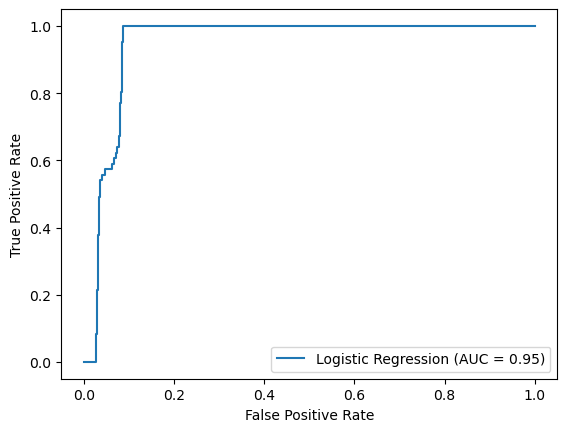

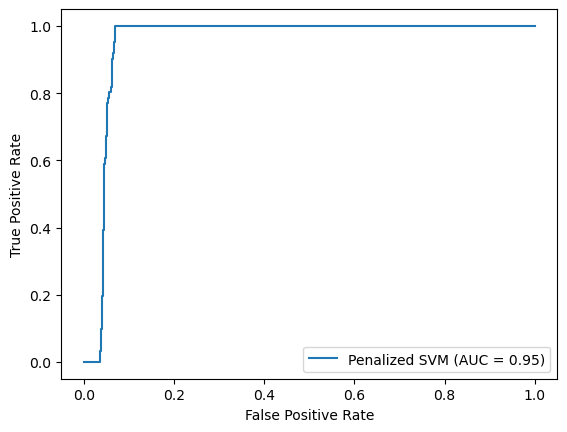

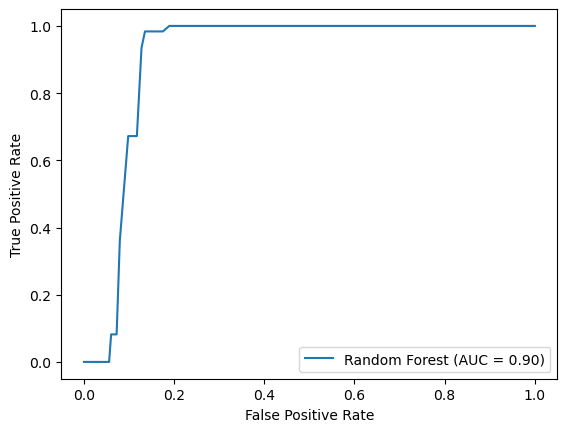

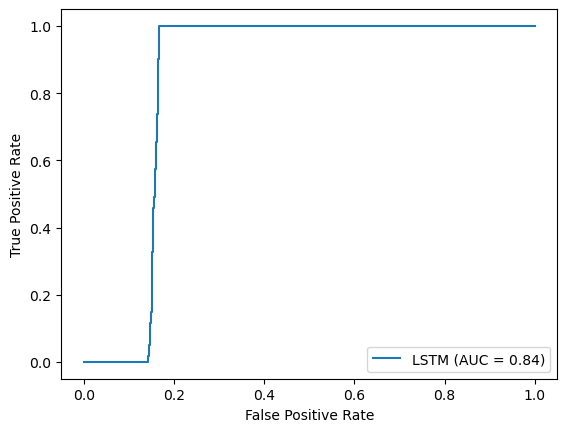

In [16]:
## Classification
for target_variable in target_variables_classification:
    print()
    print(target_variable)
    for model_name, get_model in zip(model_names_classification, get_classification_models):
        print()
        print(model_name)
        if model_name == 'LSTM':
            current_X_train, current_y_train = split_sequences(X_train.to_numpy(), y_train[target_variable].to_numpy(), n_steps=LSTM_length)
            current_X_train = current_X_train.astype(np.float32)
            current_y_train = current_y_train.astype(np.float32)
            current_X_test = pd.concat([X_train.iloc[-LSTM_length+1:], X_test])
            current_y_test = pd.concat([y_train.iloc[-LSTM_length+1:], y_test])
            current_X_test, current_y_test = split_sequences(current_X_test.to_numpy(), current_y_test[target_variable].to_numpy(), n_steps=LSTM_length)
            current_X_test = current_X_test.astype(np.float32)
            current_y_test = current_y_test.astype(np.float32)
                
        model = get_model()
        if model_name != 'LSTM':
            model.fit(X_train[features], y_train[target_variable])
            positive_probs = [p[1] for p in model.predict_proba(X_test[features])]
            AUC_ROC = metrics.roc_auc_score(y_test[target_variable], positive_probs)
            fpr, tpr, thresholds = metrics.roc_curve(y_test[target_variable], positive_probs)
        else:
            model.fit(current_X_train, current_y_train)
            positive_probs = [p[1] for p in model.predict_proba(current_X_test)]
            AUC_ROC = metrics.roc_auc_score(current_y_test, positive_probs)
            fpr, tpr, thresholds = metrics.roc_curve(current_y_test, positive_probs)
        
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
        display.plot()
        if model_name != 'LSTM':
            predictions = model.predict(X_test[features])
            ACC = accuracy_score(y_test[target_variable], predictions)
        else:
            predictions = model.predict(current_X_test)
            ACC = accuracy_score(current_y_test, predictions)
        print("Test AUC_ROC:", AUC_ROC, "\nTest Accuracy:", ACC)

    print()
    total = y_test.shape[0]
    print("Baseline #1: naively always guess 0 (no recession)\nROC AUC:", 
        metrics.roc_auc_score(y_test[target_variable], np.zeros(total)), 
        "\nAccuracy:", accuracy_score(y_test[target_variable], np.zeros(total)))

    nums = np.zeros(total)
    nums[:total//10] = 1
    np.random.shuffle(nums)
    print("Baseline #2: naively guess 1 (recession) random 10% of the time:\nROC AUC:", 
        metrics.roc_auc_score(y_test[target_variable], nums), 
        "\nAccuracy:", accuracy_score(y_test[target_variable], nums))

    nums = np.zeros(total)
    for i in range(0, total//3650):
        start = randrange(total)
        for j in range(0, 365):
            nums[start + j] = 1
    print("Baseline #3: naively guess 1 (recession) occurs once for every 3650 days, but at a random point in time, and so that there is a recession 365 days onwards from that point in time\nROC AUC:", 
        metrics.roc_auc_score(y_test[target_variable], nums), 
        "\nAccuracy:", accuracy_score(y_test[target_variable], nums))
    

In [17]:
## Regression
for target_variable in target_variables_regression:
    print()
    print(target_variable)
    for model_name, get_model in zip(model_names_regression, get_regression_models):
        print()
        print(model_name)
        
        if model_name == 'LSTM':
            current_X_train, current_y_train = split_sequences(X_train.to_numpy(), y_train[target_variable].to_numpy(), n_steps=LSTM_length)
            current_X_train = current_X_train.astype(np.float32)
            current_y_train = current_y_train.astype(np.float32)
            current_X_test = pd.concat([X_train.iloc[-LSTM_length+1:], X_test])
            current_y_test = pd.concat([y_train.iloc[-LSTM_length+1:], y_test])
            current_X_test, current_y_test = split_sequences(current_X_test.to_numpy(), current_y_test[target_variable].to_numpy(), n_steps=LSTM_length)
            current_X_test = current_X_test.astype(np.float32)
            current_y_test = current_y_test.astype(np.float32)
            
        model = get_model()
        if model_name != 'LSTM':
            model.fit(X_train[features], y_train[target_variable])
            predictions = model.predict(X_test[features])
            R2 = r2_score(y_test[target_variable], predictions)
        else:
            model.fit(current_X_train, current_y_train.reshape(-1, 1))
            predictions = model.predict(current_X_test)
            R2 = r2_score(current_y_test, predictions)
        print("Test R2:", R2)

    total = y_test.shape[0]
    print("\nBaseline #1: TODO")


GDP_rate

Linear Regression
Test R2: 0.34087958385146155

LSTM
setting random seed to:  1
Test R2: -0.03477938657341584

Baseline #1: TODO

GDP_abs

Linear Regression
Test R2: -55.15569960167359

LSTM
setting random seed to:  1
Test R2: -512.2796527269902

Baseline #1: TODO


## Final predictions

In [18]:
extended_dates = df.iloc[-lag_of_y:].index.shift(lag_of_y, freq="d").tolist()
pickle.dump(extended_dates, open('../predictions/extended_dates.pkl', 'wb'))
df_test = df.iloc[-lag_of_y:][df.columns.difference(target_variables)]

In [19]:
for target_variable in target_variables_classification:
    print()
    print(target_variable)
    for model_name, get_model in zip(model_names_classification, get_classification_models):
        print()
        print(model_name)
        model = get_model()
        if model_name != 'LSTM':
            model.fit(df_x[features], df_y[target_variable])
            predictions = model.predict(df_test[features])
        else:
            current_X_train, current_y_train = split_sequences(df_x[features].to_numpy(), df_y[target_variable].to_numpy(), n_steps=LSTM_length)
            current_X_train = current_X_train.astype(np.float32)
            current_y_train = current_y_train.astype(np.float32)
            model.fit(current_X_train, current_y_train)
            current_df_test = df.iloc[-lag_of_y-LSTM_length+1:][df.columns.difference(target_variables)]
            current_df_test = current_df_test.astype(np.float32)
            current_df_test, _ = split_sequences(current_df_test.to_numpy(), np.ones(len(current_df_test)), n_steps=LSTM_length)
            current_X_train = current_X_train.astype(np.float32)
            predictions = model.predict(current_df_test)
        pickle.dump(predictions, open('../predictions/' + model_name + '_' + target_variable + '.pkl', 'wb'))


USRECD

Logistic Regression

Penalized SVM


/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Random Forest

LSTM
setting random seed to:  1


In [20]:
for target_variable in target_variables_regression:
    print()
    print(target_variable)
    for model_name, get_model in zip(model_names_regression, get_regression_models):
        print()
        print(model_name)
        model = get_model()
        if model_name != 'LSTM':
            model.fit(df_x[features], df_y[target_variable])
            predictions = model.predict(df_test[features])
        else:
            current_X_train, current_y_train = split_sequences(df_x[features].to_numpy(), df_y[target_variable].to_numpy(), n_steps=LSTM_length)
            current_X_train = current_X_train.astype(np.float32)
            current_y_train = current_y_train.astype(np.float32)
            model.fit(current_X_train, current_y_train.reshape(-1, 1))
            current_df_test = df.iloc[-lag_of_y-LSTM_length+1:][df.columns.difference(target_variables)]
            current_df_test = current_df_test.astype(np.float32)
            current_df_test, _ = split_sequences(current_df_test.to_numpy(), np.ones(len(current_df_test)), n_steps=LSTM_length)
            current_X_train = current_X_train.astype(np.float32)
            predictions = model.predict(current_df_test)
        pickle.dump(predictions, open('../predictions/' + model_name + '_' + target_variable + '.pkl', 'wb'))
        


GDP_rate

Linear Regression

LSTM
setting random seed to:  1

GDP_abs

Linear Regression

LSTM
setting random seed to:  1
